# Higher Education R&D dataset

In [1]:
# Importing the libraries that will be useful here
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
import numpy as np
import os
%matplotlib inline

In [2]:
# reading in the data (I saved it to my local file as CSV)
ed = pd.read_csv('/Users/austinbrian/dev/blog/datasets/HERD2015_RandD_by_sector.csv')

In [56]:
# A quick look at the top of the dataset, to make sure everything came in OK
# I cheated a little here and went back to the CSV and eliminated commas, as it was a little easier to do that way
ed.head(5)

,Rank,Institution,Environmental sciences,Life sciences,Math and computer sciences,Physical sciences,Psychology,Social sciences,"Sciences, nec",Engineering,All non-S&E fields
0,1,Johns Hopkins U.,31854,867715,171205,167009,3663,11034,54640,991937,6622
1,32,"U. Illinois, Urbana-Champaign",7214,220029,114512,67182,17276,21340,5000,161458,25806
2,24,Georgia Institute of Technology,19068,19879,113353,47279,7431,9132,7645,533329,8254
3,89,Carnegie Mellon U.,348,11212,109026,14162,7757,6791,3479,89054,175
4,28,U. Southern California,20051,411987,93765,16924,9935,27941,327,69527,40574


In [57]:
ed[ed.Rank==2]

,Rank,Institution,Environmental sciences,Life sciences,Math and computer sciences,Physical sciences,Psychology,Social sciences,"Sciences, nec",Engineering,All non-S&E fields
24,2,"U. Michigan, Ann Arbor",14609,779922,25434,52449,21989,149805,1627,254505,68938


In [4]:
# This function looks at the data to make sure I don't have any missing variables
def eda(dataframe):
    print "Dataframe Shape", dataframe.shape
    print ""
    table = pd.DataFrame({"Missing": dataframe.isnull().sum(),
                          "Types": dataframe.dtypes,
                         "Uniques": [dataframe[i].nunique() for i in dataframe]})
    print table
    print ""
    print "Describe Dataframe"
    print dataframe.describe(include='all')

In [5]:
# After you make a function, you have to actually run it
eda(ed)

Dataframe Shape (640, 11)

                            Missing   Types  Uniques
Rank                              0   int64      635
Institution                       0  object      640
Environmental sciences            0   int64      408
Life sciences                     0   int64      591
Math and computer sciences        0   int64      414
Physical sciences                 0   int64      476
Psychology                        0   int64      360
Social sciences                   0   int64      397
Sciences, nec                     0   int64      233
Engineering                       0   int64      372
All non-S&E fields                0   int64      501

Describe Dataframe
              Rank                      Institution  Environmental sciences  \
count   640.000000                              640              640.000000   
unique         NaN                              640                     NaN   
top            NaN  Louisiana State U., Baton Rouge                     NaN   
f

In [6]:
X_cols = ed.columns[2:]

## Plot some distributions

In [7]:
plt.style.use('fivethirtyeight')

This function plots two dimensions by one another, and colorizes the points based on the overall school R&D value rank, with higher ranks being darker greens.

In [8]:
def plot_ed(var_X1,var_X2,c=ed.Rank,co="Greens_r"):
    plt.figure(figsize=(8,6))
    plt.scatter(ed[var_X1],ed[var_X2],c=c,cmap=co,alpha=.8)
    plt.title(var_X1+' vs '+var_X2+' R&D Research $',fontsize=18)
    plt.xlabel(var_X1,fontsize = 14)
    plt.ylabel(var_X2,fontsize = 14)

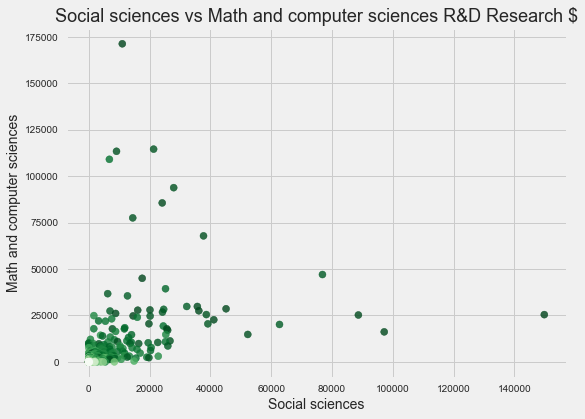

In [9]:
plot_ed('Social sciences','Math and computer sciences')

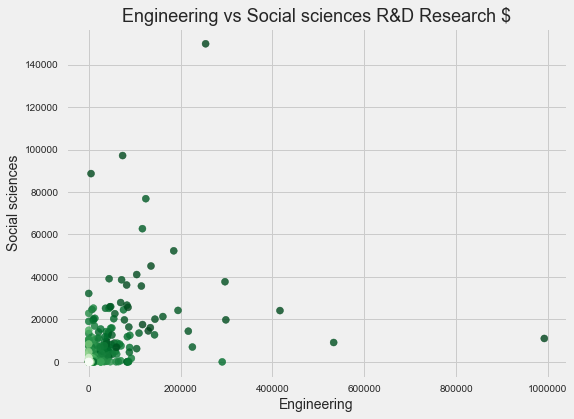

In [10]:
plot_ed('Engineering','Social sciences')

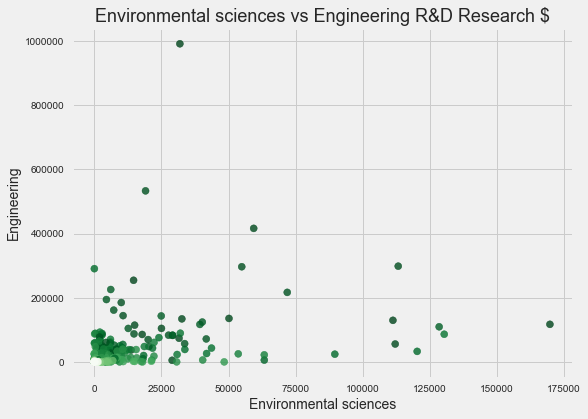

In [11]:
plot_ed('Environmental sciences','Engineering')

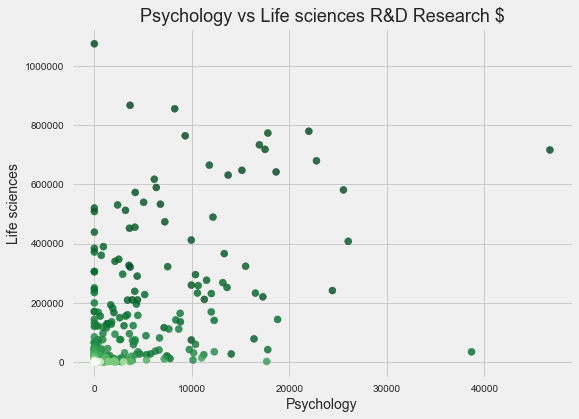

In [12]:
plot_ed('Psychology','Life sciences')

> This one's interesting! It's a bit of a closer relationship.

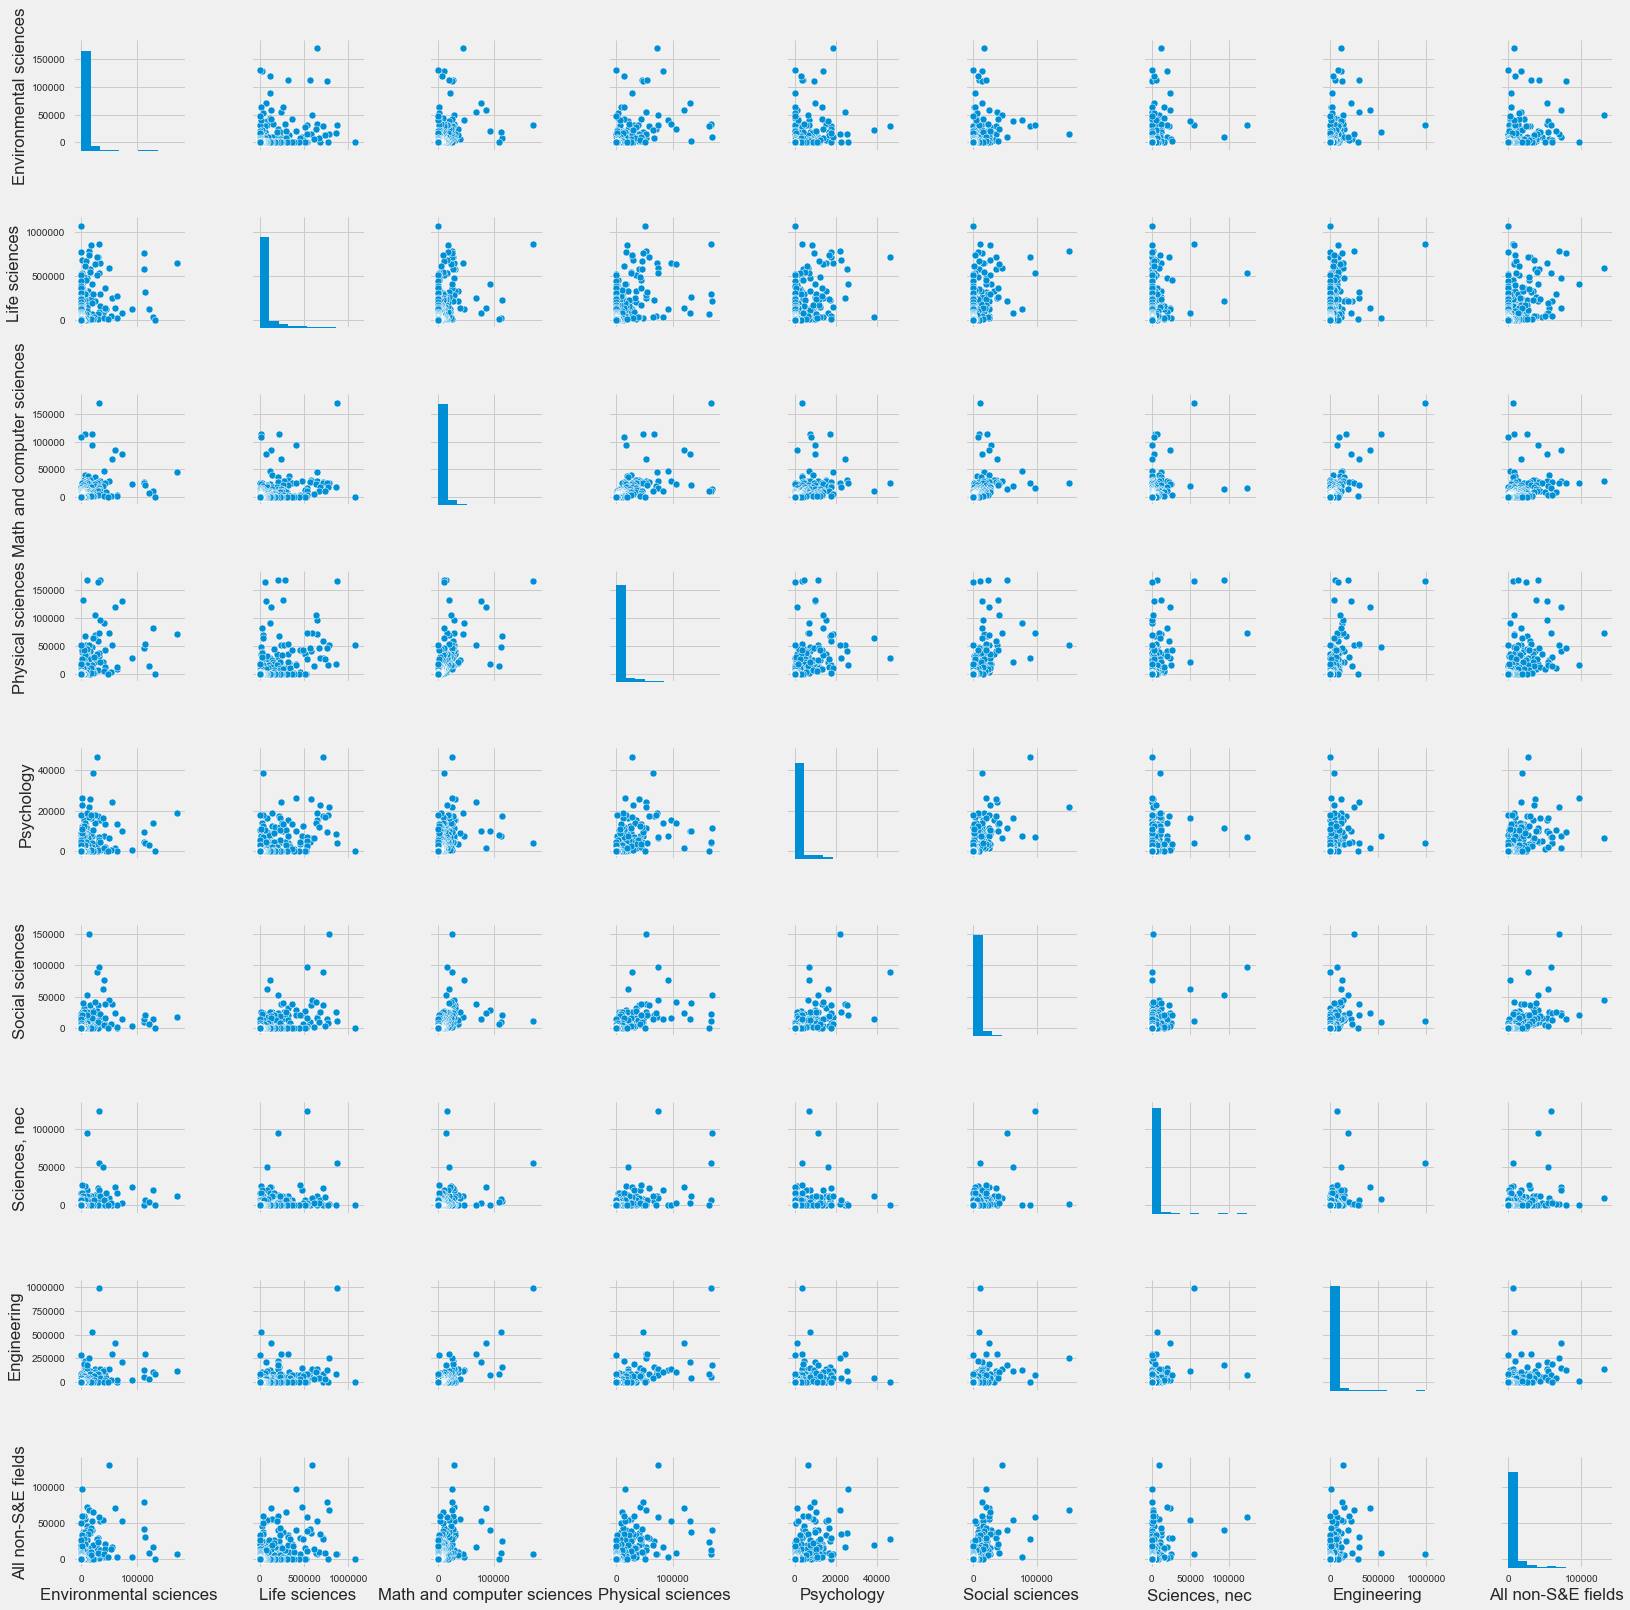

In [13]:
# Let's just plot them all.
sns.pairplot(ed[X_cols])

Interesting, but not super conclusive on anything.

## Cluster Analysis

I'm going to use both a DBSCAN clustering algorithm and a hierarchical algorithm to group schools. As the plots here show, there aren't a lot of clusters going on for any pairs, so I don't necessarily expect to get a whole lot.

The reason for looking at a cluster analysis is that we don't necessarily have a natural classification scheme for these schools. There isn't an obvious "target" to identify them as a type, so we want to find similarities within the dataset we have.

In [14]:
# more libraries
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, linear_model, metrics

### DBSCAN

In [15]:
# DBSCAN
X = ed[X_cols].values
y = ed['Rank']
dbscn = DBSCAN(eps = 1000, min_samples = 4).fit(X)  # played with epsilon and min samples
labels = dbscn.labels_  
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
cluster_groups = {}
for i in set(labels):
    cluster_groups[i]=0
    for j in labels:
        if j==i:
            cluster_groups[i]+=1
        else:
            pass
cluster_groups

{-1: 387, 0: 245, 1: 4, 2: 4}

In [16]:
print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels))  # 1 is best
print("Completeness: %0.3f" % metrics.completeness_score(y, labels)) # 1 is best
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels)) # Harmonic mean
print("Silhouette Coefficient: %0.3f" # higher is better
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 3
Homogeneity: 0.114
Completeness: 1.000
V-measure: 0.205
Silhouette Coefficient: -0.074


> This is a bad score. Our data isn't really very "dense" so a density algorithm isn't going to give us a lot of value-add here. 

>Let's look at it anyway.

In [17]:
# This is just a quick reminder of the order of our variables
X_cols

Index([u'Environmental sciences', u'Life sciences',
       u'Math and computer sciences', u'Physical sciences', u'Psychology',
       u'Social sciences', u'Sciences, nec', u'Engineering',
       u'All non-S&E fields'],
      dtype='object')

/Users/austinbrian/anaconda/lib/python2.7/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


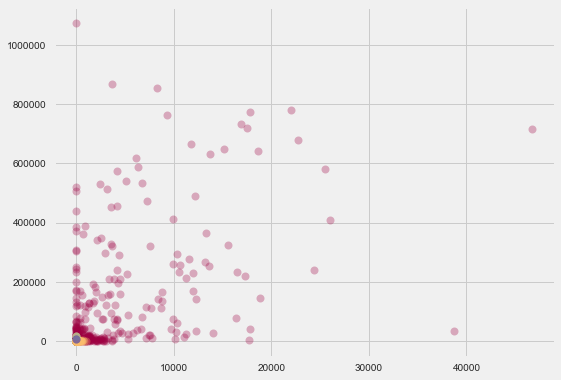

In [18]:
plt.figure(figsize=(8,6))
unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))

for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    n = X[class_member_mask] 
    # Psychology and Life Sciences Plot again
    plt.plot(n[:,4],n[:,1], 'o', markerfacecolor = color, markersize = 8,alpha=.3)

Yikes. All of our clusters but one are right around the origin - and even the lighter pink color and darker pink color aren't distinguishing features because I put a transparency setting so that I could see when the points overlapped.

### Hierarchical clustering

In [19]:
# libraries
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

In [20]:
# We'll implement the actual clustering algorithm using the ward method:
Z = linkage(X, 'ward')

# We can calculate the cophenetic correlation coefficient to see how well our algorithm has measured the distances between the points:
c, coph_dists = cophenet(Z, pdist(X))
c

0.85448874350133697

> Not bad!

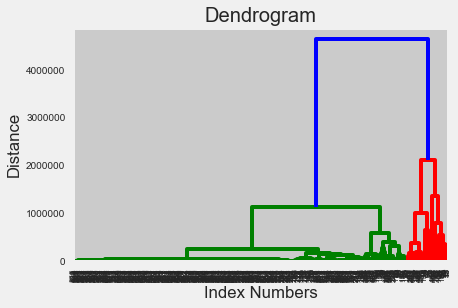

In [21]:
# Dendrogram demonstrates hierarchy
plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=8.,)
plt.show()

> It looks like there is some good separation of clusters right about the 1,000,000 point, so it's a good place to set a max value.

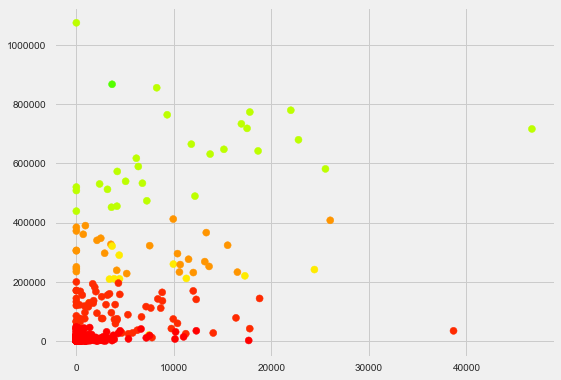

In [22]:
# we can see that no links exist above a distance of 200 - so we will set maximum distance at 200 and use the fclusters function from scipy.cluster.hierarchy, which will return our cluster ID's.
max_dist = 1000000
clusters = fcluster(Z, max_dist, criterion='distance')
clusters

# Let's plot our data and assign the class labels as the color:
plt.figure(figsize=(8,6))
plt.scatter(X[:,4], X[:,1], c=clusters, cmap='prism')
plt.show()

> Very cool! There's some identifiable separation here. We can plot more maps this same way, but first let's clean up this one.

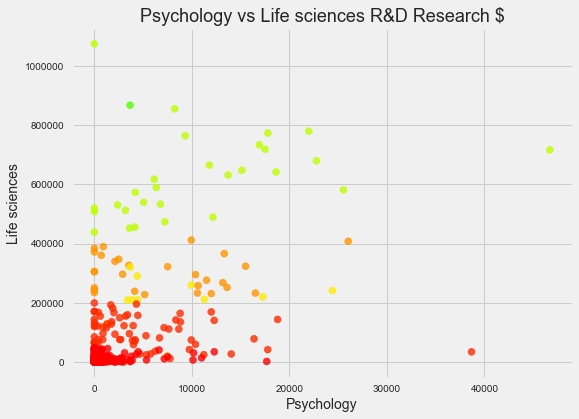

In [23]:
plot_ed('Psychology','Life sciences',c=clusters, co='prism')

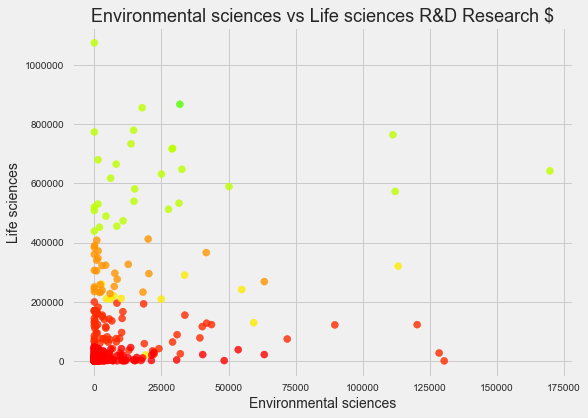

In [24]:
plot_ed('Environmental sciences','Life sciences',c=clusters, co='prism')

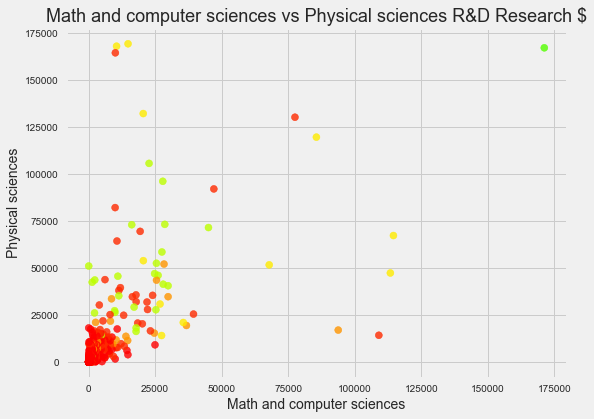

In [25]:
plot_ed('Math and computer sciences','Physical sciences',c=clusters, co='prism')

## Matching schools back to clusters
These seem like useful clusters, but it would be more useful if we could show which institutions were in which cluster.

In [34]:
for i in clusters:
    clust_zip = zip(ed.Institution, clusters)

In [35]:
clust_zip

[('Johns Hopkins U.', 6),
 ('U. Illinois, Urbana-Champaign', 4),
 ('Georgia Institute of Technology', 4),
 ('Carnegie Mellon U.', 2),
 ('U. Southern California', 3),
 ('Massachusetts Institute of Technology', 4),
 ('U. Texas, Austin', 2),
 ('Pennsylvania State U., University Park and Hershey Medical Center', 4),
 ('U. Maryland, College Park', 2),
 ('U. California, San Diego', 5),
 ('Brown U.', 2),
 ('U. Utah', 3),
 ('North Carolina State U.', 4),
 ('U. Minnesota, Twin Cities', 5),
 ('Indiana U., Bloomington', 3),
 ('U. Wisconsin-Madison', 5),
 ('U. Chicago', 3),
 ('Ohio State U.', 5),
 ('Stanford U.', 5),
 ('U. California, Los Angeles', 5),
 ('Virginia Polytechnic Institute and State U.', 4),
 ('Purdue U., West Lafayette', 4),
 ('Columbia U. in the City of New York', 5),
 ('Rutgers, State U. New Jersey, New Brunswick', 3),
 ('U. Michigan, Ann Arbor', 5),
 ('U. North Carolina, Chapel Hill', 5),
 ('U. Alabama, Huntsville', 1),
 ('U. Washington, Seattle', 5),
 ('New York U.', 3),
 ('U. Ce

In [43]:
clust_zip[0][1]

6

In [59]:
cluster_dict = {}
for i in range(1,7):
    clustername = []
    for j,v in enumerate(clust_zip):
        if clust_zip[j][1]==i:
            clustername.append(clust_zip[j][0])
    cluster_dict[i] = clustername
cluster_dict

{1: ['U. Alabama, Huntsville',
  'George Mason U.',
  'U. Alabama, Tuscaloosa',
  'Northeastern U.',
  'U. Louisiana, Lafayette',
  'U. Texas, Dallas',
  'U. Maryland, Baltimore County',
  'Naval Postgraduate School',
  'Air Force Institute of Technology',
  'SUNY, Binghamton U.',
  'U. Texas, El Paso',
  'San Diego State U.',
  'U. Texas, Arlington',
  'Worcester Polytechnic Institute',
  'U. North Texas, Denton',
  'U. North Carolina, Charlotte',
  'DePaul U.',
  'Wright State U.',
  'Syracuse U.',
  'U. Oregon',
  'U. Texas, San Antonio',
  'Rochester Institute of Technology',
  'U. Massachusetts, Lowell',
  'U.S. Air Force Academy',
  'Louisiana Tech U.',
  'Michigan Technological U.',
  'Indiana U.-Purdue U., Indianapolis',
  'U. Tulsa',
  'U. Memphis',
  'Brandeis U.',
  'Georgia State U.',
  'Boise State U.',
  'Illinois Institute of Technology',
  'U. Massachusetts, Boston',
  'North Carolina Agricultural and Technical State U.',
  'Brigham Young U., Provo',
  'U. Nebraska, Oma

In [72]:
for i in cluster_dict[6]:
    print str(i)+";",

Johns Hopkins U.;


In [67]:
for i in cluster_dict:
    print i, len(cluster_dict[i])

 1 496
2 75
3 28
4 12
5 28
6 1
